In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import chi2_contingency



In [2]:
# 1. Data Preprocessing
data_path = '/Users/crishnagarkar/Documents/R STATS/simulacrum_release_v1.2.0.2017/data/'



In [3]:
# Read data from CSV files
patient_df = pd.read_csv(data_path + 'sim_sact_patient.csv')
tumour_df = pd.read_csv(data_path + 'sim_sact_tumour.csv')
av_patient_df = pd.read_csv(data_path + 'sim_av_patient.csv')



In [26]:

# Merge datasets
merged_df = pd.merge(patient_df, tumour_df, on='MERGED_PATIENT_ID')
merged_df = pd.merge(merged_df, av_patient_df, left_on='MERGED_PATIENT_ID', right_on='PATIENTID')



In [6]:
print(merged_df.columns)


Index(['MERGED_PATIENT_ID', 'LINK_NUMBER', 'MERGED_TUMOUR_ID',
       'CONSULTANT_SPECIALITY_CODE', 'PRIMARY_DIAGNOSIS', 'MORPHOLOGY_CLEAN',
       'PATIENTID', 'SEX', 'LINKNUMBER', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       'DEATHCAUSECODE_1B', 'DEATHCAUSECODE_1C', 'DEATHCAUSECODE_2',
       'DEATHCAUSECODE_UNDERLYING', 'DEATHLOCATIONCODE', 'NEWVITALSTATUS',
       'VITALSTATUSDATE'],
      dtype='object')


In [27]:
# Handle missing values and data cleaning
merged_df = merged_df.dropna(subset=['PRIMARY_DIAGNOSIS', 'VITALSTATUSDATE', 'NEWVITALSTATUS'])



In [28]:
# Convert dates to datetime format
merged_df['VITALSTATUSDATE'] = pd.to_datetime(merged_df['VITALSTATUSDATE'])



In [10]:
# 2. Cancer Stage Analysis
stage_counts = merged_df['PRIMARY_DIAGNOSIS'].value_counts()
print("Cancer Stage Distribution:")
print(stage_counts)

Cancer Stage Distribution:
PRIMARY_DIAGNOSIS
C509    59959
C349    29377
C20     19938
C833    17705
C56     17705
        ...  
Z458        1
c821        1
D570        1
H549        1
D047        1
Name: count, Length: 814, dtype: int64


In [35]:
# 3. Survival Analysis
def calculate_survival_time(row):
    """Calculate survival time."""
    end_date = row['VITALSTATUSDATE']
    event = row['NEWVITALSTATUS'] == 'D'
    survival_time = (end_date - merged_df['VITALSTATUSDATE'].min()).days
    return survival_time, event


In [38]:
# Apply calculate_survival_time function to each row
merged_df['SURVIVAL_TIME'], merged_df['EVENT'] = zip(*merged_df.apply(calculate_survival_time, axis=1))


In [39]:
# Perform Kaplan-Meier analysis
kmf = KaplanMeierFitter()
stage_groups = merged_df['PRIMARY_DIAGNOSIS'].unique()



/var/folders/rf/rrll67zx03146l9_xq4c_9lc0000gn/T/ipykernel_63751/1201636559.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


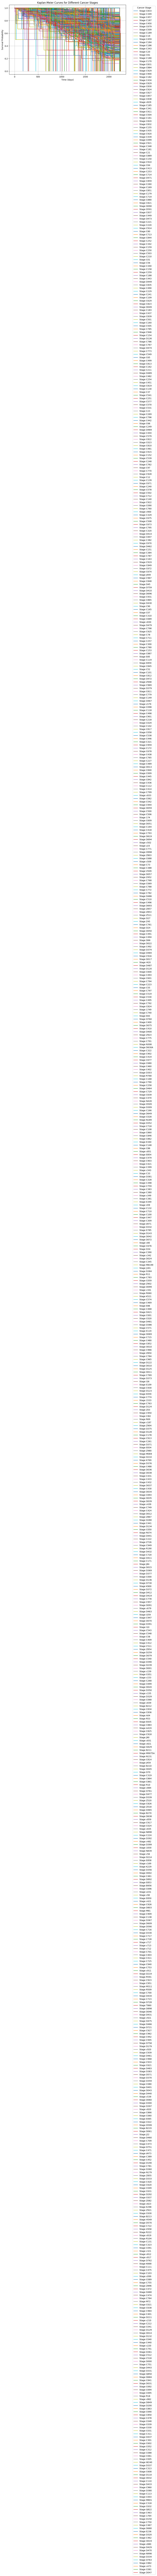

In [40]:
# Perform Kaplan-Meier analysis
kmf = KaplanMeierFitter()
stage_groups = merged_df['PRIMARY_DIAGNOSIS'].unique()

# Plot Kaplan-Meier curves for different cancer stages
plt.figure(figsize=(10, 6))
for stage in stage_groups:
    stage_data = merged_df[merged_df['PRIMARY_DIAGNOSIS'] == stage]
    if len(stage_data) > 0:
        kmf.fit(stage_data['SURVIVAL_TIME'], event_observed=stage_data['EVENT'], label=f"Stage {stage}")
        kmf.plot(ci_show=False)

plt.title('Kaplan-Meier Curves for Different Cancer Stages')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')  # Corrected label here
plt.legend(title='Cancer Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


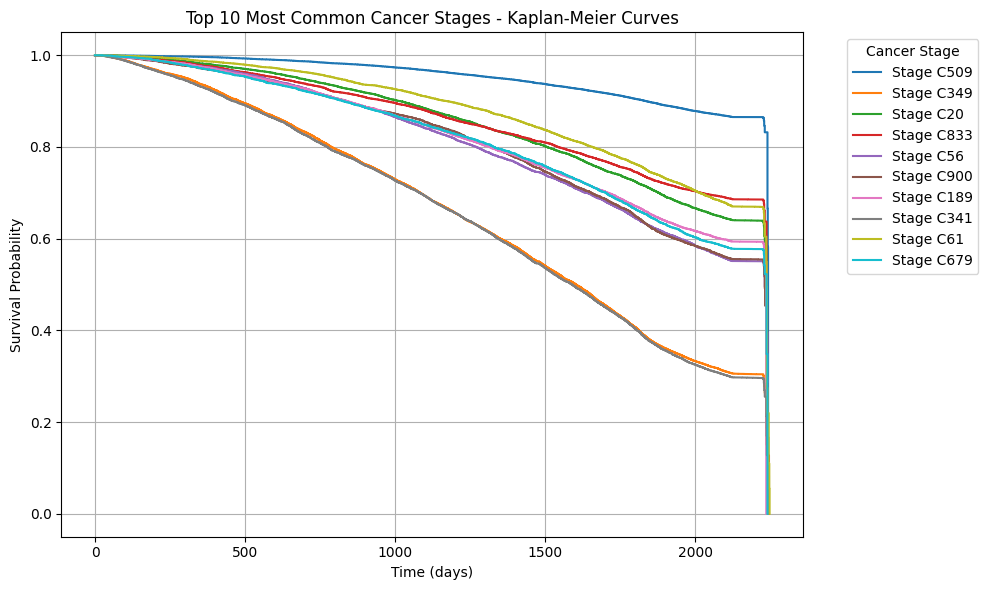

In [41]:
# Select top N most common cancer stages
top_n = 10
stage_counts = merged_df['PRIMARY_DIAGNOSIS'].value_counts().head(top_n).index

# Perform Kaplan-Meier analysis
kmf = KaplanMeierFitter()

# Plot Kaplan-Meier curves for the top N most common cancer stages
plt.figure(figsize=(10, 6))
for stage in stage_counts:
    stage_data = merged_df[merged_df['PRIMARY_DIAGNOSIS'] == stage]
    if len(stage_data) > 0:
        kmf.fit(stage_data['SURVIVAL_TIME'], event_observed=stage_data['EVENT'], label=f"Stage {stage}")
        kmf.plot(ci_show=False)

plt.title(f'Top {top_n} Most Common Cancer Stages - Kaplan-Meier Curves')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend(title='Cancer Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


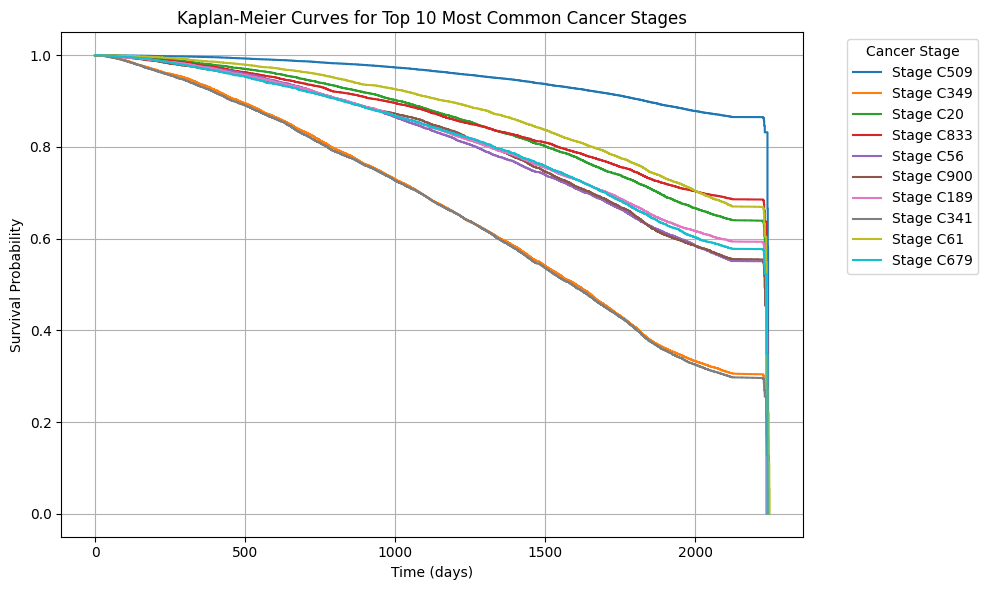

In [42]:
# Select a subset of key cancer stages
top_n = 10
top_stages = merged_df['PRIMARY_DIAGNOSIS'].value_counts().head(top_n).index

# Filter the data for the top N most common cancer stages
filtered_df = merged_df[merged_df['PRIMARY_DIAGNOSIS'].isin(top_stages)]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Perform Kaplan-Meier analysis for each top cancer stage
kmf = KaplanMeierFitter()
for stage in top_stages:
    stage_data = filtered_df[filtered_df['PRIMARY_DIAGNOSIS'] == stage]
    kmf.fit(stage_data['SURVIVAL_TIME'], event_observed=stage_data['EVENT'], label=f"Stage {stage}")
    kmf.plot(ax=ax, ci_show=False)

# Customize the plot
ax.set_title(f'Kaplan-Meier Curves for Top {top_n} Most Common Cancer Stages')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.grid(True)
ax.legend(title='Cancer Stage', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


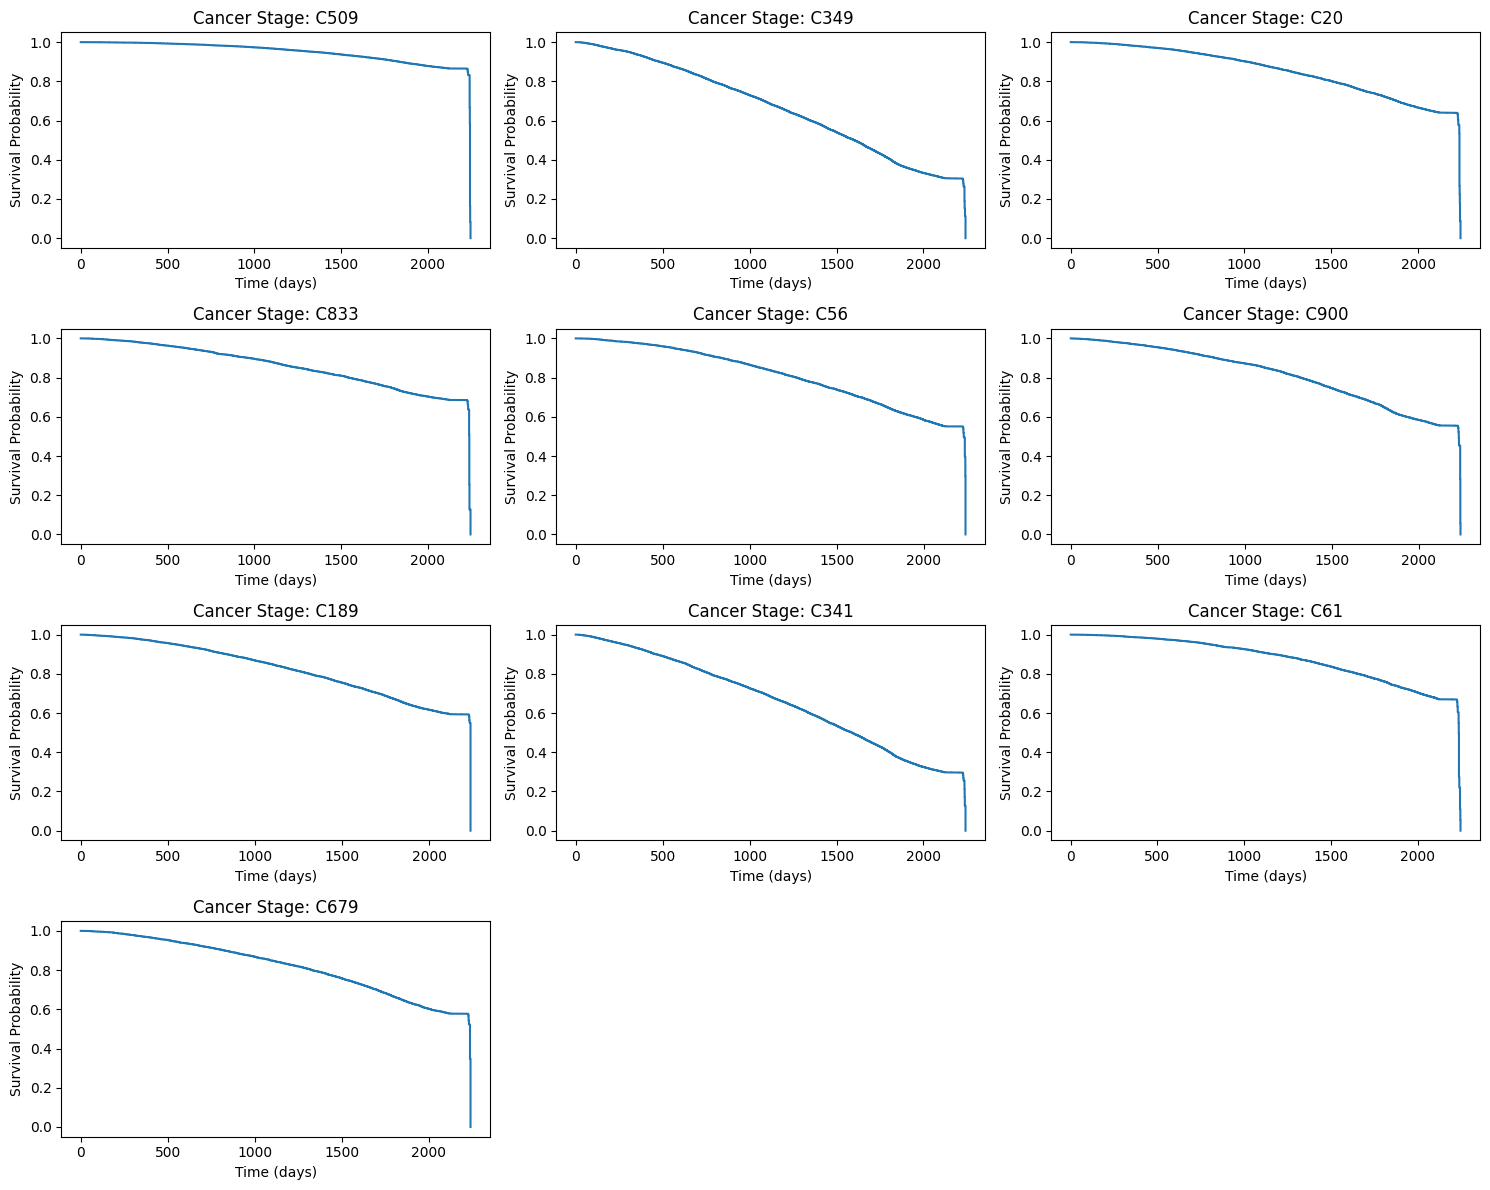

In [43]:
import math

# Set the number of top cancer stages to plot
N = 10  # You can adjust this value based on the number of stages you want to include

# Filter out rows where SURVIVAL_TIME is greater than 0
merged_df = merged_df[merged_df['SURVIVAL_TIME'] > 0]

# Get top N most frequent cancer stages
top_n_stages = merged_df['PRIMARY_DIAGNOSIS'].value_counts().nlargest(N).index

# Calculate the number of subplots required based on N
num_subplots = math.ceil(N / 3)

# Create a figure and subplots
fig, axes = plt.subplots(nrows=num_subplots, ncols=3, figsize=(15, num_subplots*3))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Perform Kaplan-Meier analysis for each cancer stage in the top N
for i, stage in enumerate(top_n_stages):
    ax = axes[i]
    stage_data = merged_df[merged_df['PRIMARY_DIAGNOSIS'] == stage]
    kmf.fit(stage_data['SURVIVAL_TIME'], event_observed=stage_data['EVENT'], label=f"Stage {stage}")
    kmf.plot(ax=ax, ci_show=False)
    ax.set_title(f'Cancer Stage: {stage}')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival Probability')
    ax.legend_.remove()  # Remove legend for better readability

# Hide empty subplots
for j in range(N, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [78]:
print(merged_df.columns)


Index(['MERGED_PATIENT_ID', 'LINK_NUMBER', 'MERGED_TUMOUR_ID',
       'CONSULTANT_SPECIALITY_CODE', 'MORPHOLOGY_CLEAN', 'PATIENTID', 'SEX',
       'LINKNUMBER', 'ETHNICITY', 'DEATHCAUSECODE_1A',
       ...
       'PRIMARY_DIAGNOSIS_c862', 'PRIMARY_DIAGNOSIS_c880',
       'PRIMARY_DIAGNOSIS_c884', 'PRIMARY_DIAGNOSIS_c90',
       'PRIMARY_DIAGNOSIS_c900', 'PRIMARY_DIAGNOSIS_c911',
       'PRIMARY_DIAGNOSIS_c920', 'PRIMARY_DIAGNOSIS_c921',
       'PRIMARY_DIAGNOSIS_d471', 'PRIMARY_DIAGNOSIS_d473'],
      dtype='object', length=832)
